<a href="https://colab.research.google.com/github/Dhananjay-97/notebooks/blob/main/airbnb_search_benchmark_colab_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛍️ Let Users Talk to Your Store: Benchmarking Retrieval Techniques

## Stockholm Airbnb Search Scenario Comparison

This notebook demonstrates a comprehensive benchmark of different retrieval techniques:

- 🔤 **BM25**: Traditional keyword-based search (fast, exact matches)
- 🧠 **Vector Search**: Dense retrieval using sentence transformers (semantic understanding)
- ⚖️ **Hybrid Search**: Combination of BM25 and vector search (balanced approach)
- 🎯 **Cross-encoder Reranking**: Advanced reranking with transformer models (highest quality)
- 🚀 **ColBERT**: ColBERT-based multi-attribute search for semantic matching
- ⚡ **Superlinked**: Mixture-of-encoders approach (production-ready)

🔗 **Blog Post**: [Read the full analysis]()


## 📦 Installation & Setup

First, let's install all required packages. This might take a few minutes on first run.

In [1]:
# Install required packages for the benchmark
!pip install -q pandas numpy scikit-learn matplotlib seaborn plotly
!pip install -q rank-bm25 sentence-transformers faiss-cpu
!pip install -q superlinked python-dotenv tqdm

print("✅ All packages installed successfully!")
print("🔄 If this is your first run, please restart runtime now and run the next cell.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  G

In [5]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import time
import warnings
from typing import List, Dict, Any, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import os
from tqdm.auto import tqdm
import random

# ML/Search libraries
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer, CrossEncoder
import faiss
from sklearn.metrics.pairwise import cosine_similarity

# Superlinked (if available)
try:
    from superlinked import framework as sl
    SUPERLINKED_AVAILABLE = True
    print("✅ Superlinked available")
except ImportError:
    SUPERLINKED_AVAILABLE = False
    print("⚠️ Superlinked not available - will skip those sections")

# Configure visualization
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("✅ All imports successful!")
print(f"📊 NumPy: {np.__version__}, Pandas: {pd.__version__}")

✅ Superlinked available
✅ All imports successful!
📊 NumPy: 2.0.2, Pandas: 2.2.2


## 🔧 Utility Functions

Let's define all utility functions (originally in separate files):

In [6]:
def measure_time(func):
    """Decorator to measure execution time of functions."""
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} executed in {end_time - start_time:.4f} seconds")
        return result
    return wrapper

def create_listing_text(row: pd.Series) -> str:
    """Create comprehensive text description from Airbnb listing data."""
    text = f"{row.get('listing_name', 'Listing')} is a {row.get('accommodation_type', 'accommodation')} "
    text += f"for {row.get('max_guests', 'N/A')} guests. "
    text += f"It costs ${row.get('price', 0):.0f} per night with a rating of {row.get('rating', 0):.2f} "
    text += f"and {row.get('review_count', 0)} reviews. "
    text += f"Description: {row.get('description', 'No description available')} "

    # Handle amenities
    amenities = row.get('amenities_list', [])
    if isinstance(amenities, list) and amenities:
        text += f"Amenities include: {', '.join(amenities)}"
    elif isinstance(amenities, str):
        text += f"Amenities: {amenities}"
    else:
        text += "Amenities: Not specified"

    return text

def create_sample_airbnb_data(n_samples: int = 1500) -> pd.DataFrame:
    """Generate realistic Stockholm Airbnb-like sample data for demo."""
    np.random.seed(42)  # For reproducible results

    # Realistic listing names
    sample_names = [
        "Cozy Stockholm Apartment", "Modern City Center Flat", "Luxury Downtown Suite",
        "Budget-Friendly Room", "Spacious Family Home", "Stylish Studio",
        "Traditional Swedish House", "Waterfront Apartment", "Historic District Room",
        "Minimalist Loft", "Garden View Studio", "Executive Suite", "Artistic Retreat",
        "Scandinavian Design Flat", "Central Station Apartment", "Quiet Residential Room",
        "Rooftop Penthouse", "Vintage Charm Apartment", "Business Traveler Suite",
        "Family-Friendly Home", "Designer Apartment", "Cozy Attic Room"
    ]

    # Realistic descriptions
    sample_descriptions = [
        "Beautiful apartment in the heart of Stockholm with modern amenities and great transport links",
        "Modern and clean space perfect for business travelers and tourists alike",
        "Luxury accommodation with stunning city views and premium furnishings throughout",
        "Affordable option for budget travelers, clean and comfortable with basic amenities",
        "Perfect for families visiting Stockholm, spacious with multiple bedrooms and family amenities",
        "Stylish studio apartment with contemporary design and efficient use of space",
        "Traditional Swedish architecture with modern comforts, offering unique cultural experience",
        "Beautiful waterfront location with amazing views and peaceful atmosphere",
        "Located in historic district, walking distance to major attractions and restaurants",
        "Minimalist design with high-end finishes, perfect for those who appreciate clean aesthetics",
        "Bright space with garden views, quiet and relaxing environment",
        "Professional accommodation with business amenities and fast internet",
        "Creative space with artistic touches, inspiring environment for creative minds",
        "Authentic Scandinavian design with quality furniture and attention to detail"
    ]

    # Realistic amenity combinations
    amenities_options = [
        ['Wifi', 'Kitchen', 'TV', 'Air conditioning'],
        ['Wifi', 'Kitchen', 'Washer', 'Heating'],
        ['Wifi', 'Kitchen', 'TV', 'Air conditioning', 'Dishwasher', 'Balcony'],
        ['Wifi', 'Heating', 'Essentials'],
        ['Wifi', 'Kitchen', 'TV', 'Washer', 'Family/kid friendly'],
        ['Wifi', 'Kitchen', 'TV', 'Air conditioning', 'Gym', 'Pool'],
        ['Wifi', 'Kitchen', 'Laptop friendly workspace', 'Self check-in'],
        ['Wifi', 'Kitchen', 'TV', 'Hair dryer', 'Iron', 'Hangers']
    ]

    # Generate the dataset
    df = pd.DataFrame({
        'listing_id': range(1, n_samples + 1),
        'listing_name': np.random.choice(sample_names, n_samples),
        'accommodation_type': np.random.choice(
            ['Entire place', 'Private room', 'Shared room'],
            n_samples,
            p=[0.65, 0.30, 0.05]  # More realistic distribution
        ),
        'max_guests': np.random.choice(
            [1, 2, 3, 4, 5, 6, 8],
            n_samples,
            p=[0.1, 0.35, 0.20, 0.20, 0.10, 0.04, 0.01]
        ),
        'price': np.clip(
            np.random.lognormal(5.5, 0.8, n_samples),
            30, 3000
        ).round(2),
        'rating': np.round(
            np.random.beta(8.5, 1.5, n_samples) * 5,  # Skewed toward higher ratings
            2
        ),
        'review_count': np.random.poisson(65, n_samples),  # Average ~65 reviews
        'description': np.random.choice(sample_descriptions, n_samples),
        'amenities_list': [
            random.choice(amenities_options)
            for _ in range(n_samples)
        ]
    })

    # Create comprehensive text descriptions
    df['text_description'] = df.apply(create_listing_text, axis=1)

    return df

def display_search_results(results: pd.DataFrame, query: str, method: str, top_k: int = 5):
    """Display search results in a nice format."""
    print(f"\n🔍 {method} Results for: '{query}'")
    print("=" * 70)

    for i, (_, row) in enumerate(results.head(top_k).iterrows(), 1):
        print(f"\n{i}. {row['listing_name']}")
        print(f"   💰 ${row['price']:.0f}/night | ⭐ {row['rating']:.2f} ({row['review_count']} reviews)")
        print(f"   🏠 {row['accommodation_type']} for {row['max_guests']} guests")
        if 'score' in row.index:
            print(f"   📊 Score: {row['score']:.4f}")
        elif 'similarity_score' in row.index:
            print(f"   📊 Similarity: {row['similarity_score']:.4f}")
        print(f"   📝 {row['description'][:80]}...")
        print("-" * 50)

print("✅ Utility functions defined!")

✅ Utility functions defined!


## 📊 Data Loading

Let's create our Stockholm Airbnb dataset for the benchmark:

In [7]:
# Generate sample Stockholm Airbnb data for demonstration
print("📁 Creating Stockholm Airbnb sample dataset...")
df = create_sample_airbnb_data(n_samples=1500)

# Alternative: Upload your own CSV file
# Uncomment the following lines to upload your own data:
# from google.colab import files
# print("📤 Upload your CSV file:")
# uploaded = files.upload()
# if uploaded:
#     filename = list(uploaded.keys())[0]
#     df = pd.read_csv(filename)
#     if 'text_description' not in df.columns:
#         df['text_description'] = df.apply(create_listing_text, axis=1)
#     print(f"✅ Custom data loaded: {len(df)} listings")

print(f"\n📋 Dataset Summary:")
print(f"- Total listings: {len(df):,}")
print(f"- Price range: ${df['price'].min():.0f} - ${df['price'].max():.0f}")
print(f"- Rating range: {df['rating'].min():.2f} - {df['rating'].max():.2f}")
print(f"- Average reviews per listing: {df['review_count'].mean():.0f}")
print(f"- Accommodation types: {df['accommodation_type'].value_counts().to_dict()}")

# Display sample data
print(f"\n🔍 Sample listings:")
display(df[['listing_name', 'accommodation_type', 'price', 'rating', 'max_guests', 'review_count']].head())

print(f"\n📝 Sample text description:")
print(f"'{df['text_description'].iloc[0][:200]}...'")

📁 Creating Stockholm Airbnb sample dataset...

📋 Dataset Summary:
- Total listings: 1,500
- Price range: $30 - $3000
- Rating range: 1.74 - 5.00
- Average reviews per listing: 65
- Accommodation types: {'Entire place': 965, 'Private room': 454, 'Shared room': 81}

🔍 Sample listings:


,listing_name,accommodation_type,price,rating,max_guests,review_count
0,Traditional Swedish House,Private room,396.47,4.64,2,73
1,Family-Friendly Home,Private room,310.61,4.53,5,61
2,Central Station Apartment,Private room,407.86,4.08,2,70
3,Garden View Studio,Entire place,570.49,3.75,6,48
4,Waterfront Apartment,Entire place,328.36,4.31,1,60



📝 Sample text description:
'Traditional Swedish House is a Private room for 2 guests. It costs $396 per night with a rating of 4.64 and 73 reviews. Description: Bright space with garden views, quiet and relaxing environment Amen...'


## 🔍 Search Method Implementations

Now let's implement all the search methods (originally in separate files):

In [8]:
class BM25Search:
    """BM25 keyword-based search implementation."""

    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.corpus = df['text_description'].tolist()
        self.tokenized_corpus = [doc.lower().split() for doc in self.corpus]
        print("🔄 Building BM25 index...")
        self.bm25 = BM25Okapi(self.tokenized_corpus)
        self.meta_data = {}

    @measure_time
    def search(self, query: str, top_k: int = 10) -> Tuple[pd.DataFrame, dict]:
        """Perform BM25 search."""
        start_time = time.time()
        tokenized_query = query.lower().split()
        scores = self.bm25.get_scores(tokenized_query)

        results = self.df.copy()
        results['score'] = scores
        results = results.sort_values('score', ascending=False).head(top_k)

        self.meta_data = {
            'method': 'BM25',
            'search_time': time.time() - start_time,
            'query': query,
            'top_k': top_k
        }

        return results, self.meta_data

print("✅ BM25Search class defined")

✅ BM25Search class defined


In [9]:
class VectorSearch:
    """Dense vector search using sentence transformers."""

    def __init__(self, df: pd.DataFrame, model_name: str = 'all-MiniLM-L12-v2'):
        self.df = df
        self.model_name = model_name
        print(f"🔄 Loading model: {model_name}")
        self.model = SentenceTransformer(model_name)

        print("🔄 Creating embeddings...")
        self.embeddings = self.model.encode(
            self.df['text_description'].tolist(),
            normalize_embeddings=True,
            show_progress_bar=True
        ).astype(np.float32)

        print("🔄 Building FAISS index...")
        self.index = self._create_faiss_index()
        self.meta_data = {}

    def _create_faiss_index(self):
        """Create FAISS index for fast similarity search."""
        vector_dimension = self.embeddings.shape[1]
        index = faiss.IndexFlatIP(vector_dimension)  # Inner product for cosine similarity
        index.add(self.embeddings)
        return index

    @measure_time
    def search(self, query: str, top_k: int = 10) -> Tuple[pd.DataFrame, dict]:
        """Perform vector similarity search."""
        start_time = time.time()

        query_embedding = self.model.encode(
            [query],
            normalize_embeddings=True
        ).astype(np.float32)

        scores, indices = self.index.search(query_embedding, top_k)

        results = self.df.iloc[indices[0]].copy()
        results['score'] = scores[0]

        self.meta_data = {
            'method': 'Vector',
            'model': self.model_name,
            'search_time': time.time() - start_time,
            'query': query,
            'top_k': top_k
        }

        return results, self.meta_data

print("✅ VectorSearch class defined")

✅ VectorSearch class defined


In [10]:
class HybridSearch:
    """Hybrid search combining BM25 and vector search."""

    def __init__(self, df: pd.DataFrame, model_name: str = 'all-MiniLM-L12-v2'):
        self.df = df
        print("🔄 Initializing BM25 component...")
        self.bm25_search = BM25Search(df)
        print("🔄 Initializing Vector component...")
        self.vector_search = VectorSearch(df, model_name)
        self.meta_data = {}

    @measure_time
    def search(self, query: str, alpha: float = 0.4, top_k: int = 10) -> Tuple[pd.DataFrame, dict]:
        """Perform hybrid search with linear combination of scores."""
        start_time = time.time()

        # Get results from both methods
        bm25_results, _ = self.bm25_search.search(query, top_k=len(self.df))
        vector_results, _ = self.vector_search.search(query, top_k=len(self.df))

        # Normalize scores to [0,1] range
        bm25_scores = bm25_results['score'].values
        bm25_scores_norm = (bm25_scores - np.min(bm25_scores)) / (np.max(bm25_scores) - np.min(bm25_scores) + 1e-8)

        vector_scores = vector_results['score'].values
        vector_scores_norm = (vector_scores - np.min(vector_scores)) / (np.max(vector_scores) - np.min(vector_scores) + 1e-8)

        # Combine scores using linear combination
        hybrid_scores = alpha * bm25_scores_norm + (1 - alpha) * vector_scores_norm

        results = self.df.copy()
        results['score'] = hybrid_scores
        results = results.sort_values('score', ascending=False).head(top_k)

        self.meta_data = {
            'method': 'Hybrid',
            'alpha': alpha,
            'search_time': time.time() - start_time,
            'query': query,
            'top_k': top_k
        }

        return results, self.meta_data

print("✅ HybridSearch class defined")

✅ HybridSearch class defined


In [11]:
class CrossEncoderSearch:
    """Cross-encoder reranking on top of initial retrieval."""

    def __init__(self, df: pd.DataFrame,
                 retriever_model: str = 'all-MiniLM-L12-v2',
                 cross_encoder_model: str = 'cross-encoder/ms-marco-MiniLM-L-6-v2'):
        self.df = df
        print("🔄 Initializing retriever...")
        self.vector_search = VectorSearch(df, retriever_model)
        print(f"🔄 Loading cross-encoder: {cross_encoder_model}")
        self.cross_encoder = CrossEncoder(cross_encoder_model)
        self.meta_data = {}

    @measure_time
    def search(self, query: str, top_k: int = 10, initial_k: int = 50) -> Tuple[pd.DataFrame, dict]:
        """Perform cross-encoder reranking."""
        start_time = time.time()

        # First stage: retrieve candidates
        initial_results, _ = self.vector_search.search(query, top_k=initial_k)

        # Second stage: rerank with cross-encoder
        descriptions = initial_results['text_description'].tolist()
        pairs = [(query, doc) for doc in descriptions]
        scores = self.cross_encoder.predict(pairs)

        # Rerank and return top results
        reranked_results = initial_results.copy()
        reranked_results['score'] = scores
        reranked_results = reranked_results.sort_values('score', ascending=False).head(top_k)

        self.meta_data = {
            'method': 'Cross-Encoder',
            'search_time': time.time() - start_time,
            'query': query,
            'top_k': top_k,
            'initial_k': initial_k
        }

        return reranked_results, self.meta_data

print("✅ CrossEncoderSearch class defined")

✅ CrossEncoderSearch class defined


In [12]:
# ColBERT Search Implementation
# Note: ColBERT requires additional setup and may not work in all Colab environments

class ColBERTSearch:
    """ColBERT late interaction search implementation."""

    def __init__(self, df: pd.DataFrame, max_docs: int = 1000):
        """Initialize ColBERT search.

        Note: This is a simplified implementation for demonstration.
        For production use, consider using the full ColBERT library.
        """
        self.df = df.head(max_docs)  # Limit for demo purposes
        self.available = False

        try:
            # Try to import ColBERT
            global colbert
            import colbert
            from colbert import Indexer, Searcher
            from colbert.infra import Run, RunConfig, ColBERTConfig

            self.colbert = colbert
            self.Indexer = Indexer
            self.Searcher = Searcher
            self.Run = Run
            self.RunConfig = RunConfig
            self.ColBERTConfig = ColBERTConfig

            print("🔄 Setting up ColBERT (this may take several minutes)...")
            self._setup_colbert()
            self.available = True
            print("✅ ColBERT setup complete")

        except ImportError:
            print("⚠️ ColBERT not available. Install with: !pip install colbert")
            self.available = False
        except Exception as e:
            print(f"⚠️ ColBERT setup failed: {e}")
            self.available = False

    def _setup_colbert(self):
        """Setup ColBERT index and searcher."""
        # Prepare collection
        self.collection = self.df['text_description'].tolist()
        self.index_name = 'airbnb_colbert_index'

        # Create text to dataframe mapping
        self.text_to_df_map = {text: idx for idx, text in enumerate(self.collection)}

        try:
            # Build index
            with self.Run().context(self.RunConfig(nranks=1, experiment='airbnb_demo')):
                config = self.ColBERTConfig(
                    doc_maxlen=300,  # Shorter for demo
                    nbits=2,         # Lower precision for speed
                    kmeans_niters=4  # Fewer iterations
                )

                indexer = self.Indexer(
                    checkpoint='colbert-ir/colbertv2.0',
                    config=config
                )

                indexer.index(
                    name=self.index_name,
                    collection=self.collection,
                    overwrite=True
                )

            # Initialize searcher
            with self.Run().context(self.RunConfig(experiment='airbnb_demo')):
                self.searcher = self.Searcher(
                    index=self.index_name,
                    collection=self.collection
                )

        except Exception as e:
            print(f"ColBERT indexing failed: {e}")
            # Fallback to vector search for demo
            print("🔄 Falling back to vector search simulation...")
            self._setup_fallback()

    def _setup_fallback(self):
        """Setup fallback vector search to simulate ColBERT."""
        from sentence_transformers import SentenceTransformer
        import faiss

        self.fallback_model = SentenceTransformer('all-MiniLM-L12-v2')
        embeddings = self.fallback_model.encode(
            self.collection,
            normalize_embeddings=True
        ).astype(np.float32)

        # Create FAISS index
        self.fallback_index = faiss.IndexFlatIP(embeddings.shape[1])
        self.fallback_index.add(embeddings)
        self.using_fallback = True

    @measure_time
    def search(self, query: str, top_k: int = 10) -> Tuple[pd.DataFrame, dict]:
        """Perform ColBERT search."""
        if not self.available:
            raise RuntimeError("ColBERT not available")

        start_time = time.time()

        try:
            if hasattr(self, 'using_fallback') and self.using_fallback:
                # Use fallback vector search
                query_embedding = self.fallback_model.encode(
                    [query],
                    normalize_embeddings=True
                ).astype(np.float32)

                scores, indices = self.fallback_index.search(query_embedding, top_k)

                results = self.df.iloc[indices[0]].copy()
                results['score'] = scores[0]

            else:
                # Use actual ColBERT
                colbert_results = self.searcher.search(query, k=top_k)

                # Process ColBERT results
                matched_records = []
                for passage_id, passage_rank, passage_score in zip(*colbert_results):
                    if passage_id < len(self.df):
                        record = self.df.iloc[passage_id].copy()
                        record['score'] = passage_score
                        matched_records.append(record)

                results = pd.DataFrame(matched_records) if matched_records else pd.DataFrame()

            meta_data = {
                'method': 'ColBERT',
                'search_time': time.time() - start_time,
                'query': query,
                'top_k': top_k,
                'using_fallback': getattr(self, 'using_fallback', False)
            }

            return results, meta_data

        except Exception as e:
            print(f"ColBERT search failed: {e}")
            # Return empty results
            return pd.DataFrame(), {
                'method': 'ColBERT',
                'search_time': time.time() - start_time,
                'error': str(e)
            }

# Try to initialize ColBERT (optional)
try:
    print("🔄 Attempting to initialize ColBERT...")
    print("Note: This may take several minutes and requires significant memory.")
    print("If it fails, the benchmark will continue without ColBERT.")

    # Only try with a small subset for demo
    colbert_searcher = ColBERTSearch(df, max_docs=500)
    COLBERT_AVAILABLE = colbert_searcher.available

    if COLBERT_AVAILABLE:
        print("✅ ColBERT initialized successfully")
    else:
        print("⚠️ ColBERT initialization failed")

except Exception as e:
    print(f"⚠️ ColBERT setup error: {e}")
    COLBERT_AVAILABLE = False

print(f"\n📊 ColBERT Status: {'Available' if COLBERT_AVAILABLE else 'Not Available'}")

🔄 Attempting to initialize ColBERT...
Note: This may take several minutes and requires significant memory.
If it fails, the benchmark will continue without ColBERT.
⚠️ ColBERT not available. Install with: !pip install colbert
⚠️ ColBERT initialization failed

📊 ColBERT Status: Not Available


In [13]:
class SuperlinkedSearch:
    """Superlinked mixture-of-encoders search implementation."""

    def __init__(self, df: pd.DataFrame):
        if not SUPERLINKED_AVAILABLE:
            raise ImportError("Superlinked not available")

        self.df = df
        self._setup_superlinked()

    def _setup_superlinked(self):
        """Setup Superlinked schema, spaces, and index."""
        print("🔄 Setting up Superlinked...")

        # Define schema
        class AirbnbSchema(sl.Schema):
            listing_id: sl.IdField
            price: sl.Float
            rating: sl.Float
            description: sl.String
            review_count: sl.Integer
            listing_name: sl.String
            accommodation_type: sl.String
            max_guests: sl.Integer

        self.airbnb_schema = AirbnbSchema()

        # Create embedding spaces
        self.description_space = sl.TextSimilaritySpace(
            text=self.airbnb_schema.description,
            model="sentence-transformers/all-MiniLM-L12-v2"
        )

        self.price_space = sl.NumberSpace(
            self.airbnb_schema.price,
            min_value=0,
            max_value=3000.0,
            mode=sl.Mode.MAXIMUM,
        )

        self.rating_space = sl.NumberSpace(
            number=self.airbnb_schema.rating,
            min_value=1.0,
            max_value=5.0,
            mode=sl.Mode.MAXIMUM
        )

        # Create index
        self.airbnb_index = sl.Index(
            spaces=[
                self.description_space,
                self.price_space,
                self.rating_space,
            ],
            fields=[
                self.airbnb_schema.accommodation_type,
                self.airbnb_schema.max_guests,
                self.airbnb_schema.price,
                self.airbnb_schema.rating,
                self.airbnb_schema.review_count,
            ]
        )

        # Setup query
        self.query = (
            sl.Query(
                self.airbnb_index,
                weights={
                    self.price_space: sl.Param("price_weight"),
                    self.rating_space: sl.Param("rating_weight"),
                    self.description_space: sl.Param("description_weight"),
                },
            )
            .find(self.airbnb_schema)
            .similar(
                self.description_space,
                sl.Param("description_query")
            )
            .filter(self.airbnb_schema.price >= sl.Param("min_price"))
            .filter(self.airbnb_schema.max_guests >= sl.Param("min_guests"))
            .filter(self.airbnb_schema.rating >= sl.Param("min_rating"))
            .limit(sl.Param("limit"))
        )

        # Setup executor
        self.source = sl.InMemorySource(self.airbnb_schema)
        self.executor = sl.InMemoryExecutor(sources=[self.source], indices=[self.airbnb_index])
        self.app = self.executor.run()

        # Ingest data
        data_dicts = self.df.to_dict('records')
        self.source.put(data_dicts)

        print("✅ Superlinked setup complete")

    @measure_time
    def search(self, natural_query: str, top_k: int = 10) -> Tuple[pd.DataFrame, dict]:
        """Perform Superlinked search with natural language query."""
        start_time = time.time()

        # Simple query parameter extraction (in practice, use .with_natural_query() )
        params = {
            "description_query": natural_query,
            "description_weight": 1.0,
            "price_weight": -0.5 if "affordable" in natural_query.lower() or "budget" in natural_query.lower() else 0.5 if "luxury" in natural_query.lower() or "expensive" in natural_query.lower() else 0.0,
            "rating_weight": 1.0 if any(word in natural_query.lower() for word in ["good", "great", "excellent", "high rating"]) else 0.5,
            "min_price": 0,
            "min_guests": 1,
            "min_rating": 0.0,
            "limit": top_k
        }

        result = self.app.query(self.query, **params)
        results_df = sl.PandasConverter.to_pandas(result)

        meta_data = {
            'method': 'Superlinked',
            'search_time': time.time() - start_time,
            'top_k': top_k,
            'params': params
        }

        return results_df, meta_data

if SUPERLINKED_AVAILABLE:
    print("✅ SuperlinkedSearch class defined")
else:
    print("⚠️ SuperlinkedSearch skipped (not available)")

✅ SuperlinkedSearch class defined


## 🚀 Initialize Search Methods

Let's initialize all our search methods. This will take a few minutes as we build indices and load models:

In [14]:
print("🚀 Initializing search methods...")
print("This may take a few minutes on first run...\n")

# Initialize BM25
print("1️⃣ Initializing BM25...")
bm25_searcher = BM25Search(df)
print("✅ BM25 ready\n")

# Initialize Vector Search
print("2️⃣ Initializing Vector Search...")
vector_searcher = VectorSearch(df)
print("✅ Vector Search ready\n")

# Initialize Hybrid Search
print("3️⃣ Initializing Hybrid Search...")
hybrid_searcher = HybridSearch(df)
print("✅ Hybrid Search ready\n")

# Initialize Cross-Encoder (optional - takes longer)
print("4️⃣ Initializing Cross-Encoder (this may take a while)...")
try:
    cross_encoder_searcher = CrossEncoderSearch(df)
    print("✅ Cross-Encoder ready\n")
    CROSS_ENCODER_AVAILABLE = True
except Exception as e:
    print(f"⚠️ Cross-Encoder failed to initialize: {e}")
    CROSS_ENCODER_AVAILABLE = False


# Initialize ColBERT (if available)
if COLBERT_AVAILABLE:
    print("🔄 ColBERT already initialized during class definition")
    print("✅ ColBERT ready for search\n")
else:
    print("⚠️ ColBERT not available - skipping\n")
# Initialize Superlinked (if available)
if SUPERLINKED_AVAILABLE:
    print("5️⃣ Initializing Superlinked...")
    try:
        superlinked_searcher = SuperlinkedSearch(df)
        print("✅ Superlinked ready\n")
        SUPERLINKED_READY = True
    except Exception as e:
        print(f"⚠️ Superlinked failed to initialize: {e}")
        SUPERLINKED_READY = False
else:
    SUPERLINKED_READY = False

print("🎉 Search method initialization complete!")
print(f"📊 Available methods: BM25, Vector, Hybrid{', Cross-Encoder' if CROSS_ENCODER_AVAILABLE else ''}{', ColBERT' if COLBERT_AVAILABLE else ''}{', Superlinked' if SUPERLINKED_READY else ''}")

🚀 Initializing search methods...
This may take a few minutes on first run...

1️⃣ Initializing BM25...
🔄 Building BM25 index...
✅ BM25 ready

2️⃣ Initializing Vector Search...
🔄 Loading model: all-MiniLM-L12-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

🔄 Creating embeddings...


Batches:   0%|          | 0/47 [00:00<?, ?it/s]

🔄 Building FAISS index...
✅ Vector Search ready

3️⃣ Initializing Hybrid Search...
🔄 Initializing BM25 component...
🔄 Building BM25 index...
🔄 Initializing Vector component...
🔄 Loading model: all-MiniLM-L12-v2
🔄 Creating embeddings...


Batches:   0%|          | 0/47 [00:00<?, ?it/s]

🔄 Building FAISS index...
✅ Hybrid Search ready

4️⃣ Initializing Cross-Encoder (this may take a while)...
🔄 Initializing retriever...
🔄 Loading model: all-MiniLM-L12-v2
🔄 Creating embeddings...


Batches:   0%|          | 0/47 [00:00<?, ?it/s]

🔄 Building FAISS index...
🔄 Loading cross-encoder: cross-encoder/ms-marco-MiniLM-L-6-v2


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

✅ Cross-Encoder ready

⚠️ ColBERT not available - skipping

5️⃣ Initializing Superlinked...
🔄 Setting up Superlinked...


Fetching 29 files:   0%|          | 0/29 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

data_config.json: 0.00B [00:00, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

onnx/model.onnx:   0%|          | 0.00/133M [00:00<?, ?B/s]

onnx/model_O4.onnx:   0%|          | 0.00/66.6M [00:00<?, ?B/s]

onnx/model_O3.onnx:   0%|          | 0.00/133M [00:00<?, ?B/s]

onnx/model_O2.onnx:   0%|          | 0.00/133M [00:00<?, ?B/s]

onnx/model_qint8_avx512.onnx:   0%|          | 0.00/34.1M [00:00<?, ?B/s]

onnx/model_O1.onnx:   0%|          | 0.00/133M [00:00<?, ?B/s]

onnx/model_quint8_avx2.onnx:   0%|          | 0.00/34.2M [00:00<?, ?B/s]

openvino_model.xml: 0.00B [00:00, ?B/s]

openvino/openvino_model.bin:   0%|          | 0.00/133M [00:00<?, ?B/s]

openvino/openvino_model_qint8_quantized.(…):   0%|          | 0.00/33.8M [00:00<?, ?B/s]

openvino_model_qint8_quantized.xml: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/134M [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/134M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

train_script.py: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

✅ Superlinked setup complete
✅ Superlinked ready

🎉 Search method initialization complete!
📊 Available methods: BM25, Vector, Hybrid, Cross-Encoder, Superlinked


## 🎯 Running the Benchmark

Now let's run our comprehensive benchmark with different test queries:

In [15]:
# Define test queries that showcase different search scenarios
test_queries = [
    "affordable places with good reviews",
    "luxury apartment for 4 guests",
    "modern studio with kitchen and wifi",
    "family friendly accommodation near city center",
    "budget room for solo traveler",
    "spacious apartment with great amenities",
    "cozy place for couples"
]

def run_search_comparison(query: str, top_k: int = 5):
    """Run all available search methods and compare results."""
    print(f"\n🔍 Query: '{query}'")
    print("=" * 80)

    results = {}

    # BM25
    bm25_results, bm25_meta = bm25_searcher.search(query, top_k)
    results['BM25'] = (bm25_results, bm25_meta)
    print(f"✅ BM25: {bm25_meta['search_time']:.4f}s")

    # Vector Search
    vector_results, vector_meta = vector_searcher.search(query, top_k)
    results['Vector'] = (vector_results, vector_meta)
    print(f"✅ Vector: {vector_meta['search_time']:.4f}s")

    # Hybrid Search
    hybrid_results, hybrid_meta = hybrid_searcher.search(query, top_k=top_k)
    results['Hybrid'] = (hybrid_results, hybrid_meta)
    print(f"✅ Hybrid: {hybrid_meta['search_time']:.4f}s")

    # Cross-Encoder (if available)
    if CROSS_ENCODER_AVAILABLE:
        try:
            ce_results, ce_meta = cross_encoder_searcher.search(query, top_k)
            results['Cross-Encoder'] = (ce_results, ce_meta)
            print(f"✅ Cross-Encoder: {ce_meta['search_time']:.4f}s")
        except Exception as e:
            print(f"⚠️ Cross-Encoder error: {e}")


    # ColBERT (if available)
    if COLBERT_AVAILABLE:
        try:
            colbert_results, colbert_meta = colbert_searcher.search(query, top_k)
            results['ColBERT'] = (colbert_results, colbert_meta)
            print(f"✅ ColBERT: {colbert_meta['search_time']:.4f}s")
        except Exception as e:
            print(f"⚠️ ColBERT error: {e}")
    # Superlinked (if available)
    if SUPERLINKED_READY:
        try:
            sl_results, sl_meta = superlinked_searcher.search(query, top_k)
            results['Superlinked'] = (sl_results, sl_meta)
            print(f"✅ Superlinked: {sl_meta['search_time']:.4f}s")
        except Exception as e:
            print(f"⚠️ Superlinked error: {e}")

    return results

# Run benchmark on first query
sample_query = test_queries[0]
print(f"🚀 Running benchmark with query: '{sample_query}'")
sample_results = run_search_comparison(sample_query)

print("\n🎉 Benchmark complete!")

🚀 Running benchmark with query: 'affordable places with good reviews'

🔍 Query: 'affordable places with good reviews'
search executed in 0.0092 seconds
✅ BM25: 0.0092s
search executed in 0.0732 seconds
✅ Vector: 0.0731s
search executed in 0.0034 seconds
search executed in 0.0151 seconds
search executed in 0.0199 seconds
✅ Hybrid: 0.0198s
search executed in 0.0115 seconds
search executed in 0.0886 seconds
✅ Cross-Encoder: 0.0885s
search executed in 0.0414 seconds
✅ Superlinked: 0.0414s

🎉 Benchmark complete!


## 📊 Results Analysis

Let's analyze and compare the results from different search methods:

In [18]:
# Display detailed results comparison
print("📋 DETAILED RESULTS COMPARISON")
print("=" * 80)

for method, (results_df, meta) in sample_results.items():
    print(f"\n🔹 {method} Results (Search time: {meta['search_time']:.4f}s):")
    print("-" * 60)

    # Handle Superlinked results which might not have all columns
    if method == 'Superlinked' and not results_df.empty:
        # Ensure 'id' column in Superlinked results matches dtype of 'listing_id' in df
        results_df['id'] = results_df['id'].astype(df['listing_id'].dtype)
        # Merge with the original DataFrame to get all listing details
        # Assuming 'id' in Superlinked results corresponds to 'listing_id' in df
        results_df = pd.merge(results_df, df, left_on='id', right_on='listing_id', how='left')
        # Use 'similarity_score' from Superlinked results if available, otherwise use 'score'
        score_col = 'similarity_score' if 'similarity_score' in results_df.columns else 'score'
    else:
        score_col = 'score' # Default score column for other methods

    for i, (_, row) in enumerate(results_df.head(3).iterrows(), 1):
        print(f"\n  {i}. {row['listing_name']}")
        print(f"     💰 ${row['price']:.0f}/night | ⭐ {row['rating']:.2f} ({row['review_count']} reviews)")
        print(f"     🏠 {row['accommodation_type']} for {row['max_guests']} guests")
        if score_col in row.index:
            print(f"     📊 Score: {row[score_col]:.4f}")
        print(f"     📝 {row['description'][:80]}...")

    print("\n" + "-" * 60)

📋 DETAILED RESULTS COMPARISON

🔹 BM25 Results (Search time: 0.0092s):
------------------------------------------------------------

  1. Rooftop Penthouse
     💰 $75/night | ⭐ 3.29 (63 reviews)
     🏠 Entire place for 2 guests
     📊 Score: 4.6222
     📝 Affordable option for budget travelers, clean and comfortable with basic ameniti...

  2. Artistic Retreat
     💰 $129/night | ⭐ 4.32 (65 reviews)
     🏠 Private room for 2 guests
     📊 Score: 4.6222
     📝 Affordable option for budget travelers, clean and comfortable with basic ameniti...

  3. Family-Friendly Home
     💰 $620/night | ⭐ 4.65 (80 reviews)
     🏠 Entire place for 2 guests
     📊 Score: 4.6222
     📝 Affordable option for budget travelers, clean and comfortable with basic ameniti...

------------------------------------------------------------

🔹 Vector Results (Search time: 0.0731s):
------------------------------------------------------------

  1. Budget-Friendly Room
     💰 $570/night | ⭐ 4.91 (72 reviews)
     🏠 En

## 📈 Performance Analysis & Visualization

Let's create visualizations to compare the performance of different methods:

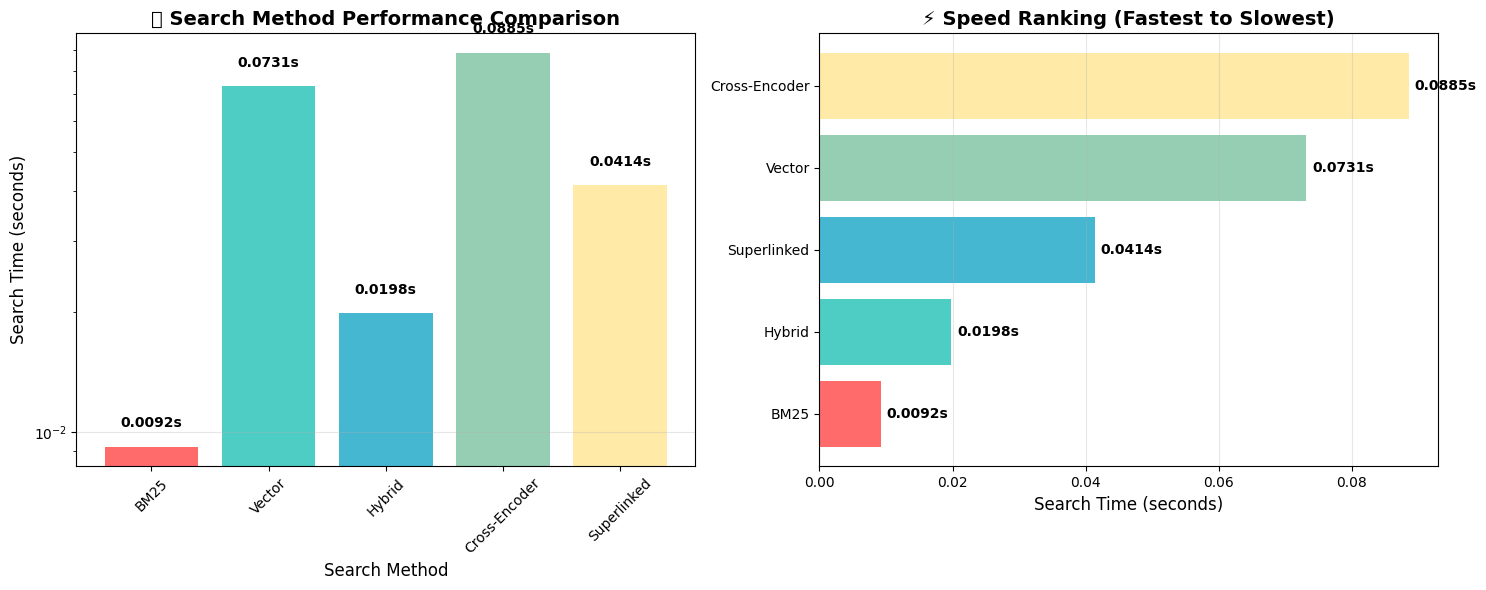


📊 PERFORMANCE SUMMARY:
🥇 1. BM25           : 0.0092s
🥈 2. Hybrid         : 0.0198s
🥉 3. Superlinked    : 0.0414s
📊 4. Vector         : 0.0731s
📊 5. Cross-Encoder  : 0.0885s

⚡ BM25 is 9.6x faster than Cross-Encoder


In [19]:
# Create performance comparison charts
def create_performance_analysis(results_dict):
    """Create comprehensive performance analysis."""

    # Extract performance data
    methods = []
    search_times = []

    for method, (_, meta) in results_dict.items():
        methods.append(method)
        search_times.append(meta['search_time'])

    # Create performance chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Search time comparison
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']
    bars = ax1.bar(methods, search_times, color=colors[:len(methods)])
    ax1.set_title('🚀 Search Method Performance Comparison', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Search Method', fontsize=12)
    ax1.set_ylabel('Search Time (seconds)', fontsize=12)
    ax1.set_yscale('log')

    # Add value labels on bars
    for bar, time_val in zip(bars, search_times):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1,
                f'{time_val:.4f}s', ha='center', va='bottom', fontweight='bold')

    ax1.grid(axis='y', alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    # Speed ranking
    speed_ranking = sorted(zip(methods, search_times), key=lambda x: x[1])
    rank_methods, rank_times = zip(*speed_ranking)

    ax2.barh(range(len(rank_methods)), rank_times, color=colors[:len(rank_methods)])
    ax2.set_yticks(range(len(rank_methods)))
    ax2.set_yticklabels(rank_methods)
    ax2.set_title('⚡ Speed Ranking (Fastest to Slowest)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Search Time (seconds)', fontsize=12)
    ax2.grid(axis='x', alpha=0.3)

    # Add time labels
    for i, time_val in enumerate(rank_times):
        ax2.text(time_val + max(rank_times) * 0.01, i, f'{time_val:.4f}s',
                va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Performance summary
    print("\n📊 PERFORMANCE SUMMARY:")
    print("=" * 50)
    for i, (method, time_val) in enumerate(speed_ranking, 1):
        emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "📊"
        print(f"{emoji} {i}. {method:15s}: {time_val:.4f}s")

    fastest = speed_ranking[0]
    slowest = speed_ranking[-1]
    speedup = slowest[1] / fastest[1]
    print(f"\n⚡ {fastest[0]} is {speedup:.1f}x faster than {slowest[0]}")

# Create the analysis
create_performance_analysis(sample_results)

## 🎮 Interactive Testing

Try different queries to see how each method performs:

In [21]:
# Interactive testing function
def test_multiple_queries():
    """Test multiple queries and show comparative results."""
    print("🎮 MULTI-QUERY TESTING")
    print("=" * 50)

    # Test with different query types
    test_scenarios = [
        ("luxury apartment with great reviews", "Luxury + Quality"),
        ("budget friendly room for students", "Budget + Target Audience"),
        ("family apartment with kitchen", "Family + Amenities")
    ]

    all_performance = {}

    for query, scenario in test_scenarios:
        print(f"\n🔍 Testing: {scenario}")
        print(f"Query: '{query}'")
        print("-" * 60)

        results = run_search_comparison(query, top_k=3)

        # Collect performance data
        for method, (_, meta) in results.items():
            if method not in all_performance:
                all_performance[method] = []
            all_performance[method].append(meta['search_time'])

        # Show top result from each method
        print("\n🏆 Top result from each method:")
        for method, (results_df, meta) in results.items():
            if not results_df.empty:
                # Handle Superlinked results which might not have all columns
                if method == 'Superlinked':
                    # Ensure 'id' column in Superlinked results matches dtype of 'listing_id' in df
                    results_df['id'] = results_df['id'].astype(df['listing_id'].dtype)
                    # Merge with the original DataFrame to get all listing details
                    results_df = pd.merge(results_df, df, left_on='id', right_on='listing_id', how='left')

                top_result = results_df.iloc[0]
                print(f"  {method:12s}: {top_result['listing_name']} (${top_result['price']:.0f}, ⭐{top_result['rating']:.2f})")

    # Average performance analysis
    print("\n\n📊 AVERAGE PERFORMANCE ACROSS ALL QUERIES:")
    print("=" * 60)

    avg_performance = []
    for method, times in all_performance.items():
        avg_time = np.mean(times)
        std_time = np.std(times)
        avg_performance.append((method, avg_time, std_time))
        print(f"{method:15s}: {avg_time:.4f}s ± {std_time:.4f}s")

    # Sort by average performance
    avg_performance.sort(key=lambda x: x[1])
    print(f"\n🏆 Most consistent performer: {avg_performance[0][0]}")

# Run the interactive testing
test_multiple_queries()

🎮 MULTI-QUERY TESTING

🔍 Testing: Luxury + Quality
Query: 'luxury apartment with great reviews'
------------------------------------------------------------

🔍 Query: 'luxury apartment with great reviews'
search executed in 0.0049 seconds
✅ BM25: 0.0049s
search executed in 0.0126 seconds
✅ Vector: 0.0126s
search executed in 0.0040 seconds
search executed in 0.0135 seconds
search executed in 0.0190 seconds
✅ Hybrid: 0.0189s
search executed in 0.0117 seconds
search executed in 0.0978 seconds
✅ Cross-Encoder: 0.0978s
search executed in 0.0182 seconds
✅ Superlinked: 0.0181s

🏆 Top result from each method:
  BM25        : Luxury Downtown Suite ($372, ⭐4.96)
  Vector      : Luxury Downtown Suite ($92, ⭐4.84)
  Hybrid      : Traditional Swedish House ($396, ⭐4.64)
  Cross-Encoder: Luxury Downtown Suite ($3000, ⭐4.01)
  Superlinked : Rooftop Penthouse ($2326, ⭐4.09)

🔍 Testing: Budget + Target Audience
Query: 'budget friendly room for students'
-------------------------------------------------

## 🎯 Quality Analysis

Let's analyze the quality of results from different methods:

In [23]:
def analyze_result_quality(query: str, results_dict: dict):
    """Analyze the quality and diversity of search results."""
    print(f"\n🔍 QUALITY ANALYSIS FOR: '{query}'")
    print("=" * 70)

    quality_metrics = {}

    for method, (results_df, meta) in results_dict.items():
        if results_df.empty:
            continue

        # Handle Superlinked results which might not have all columns
        if method == 'Superlinked':
            # Ensure 'id' column in Superlinked results matches dtype of 'listing_id' in df
            results_df['id'] = results_df['id'].astype(df['listing_id'].dtype)
            # Merge with the original DataFrame to get all listing details
            # Assuming 'id' in Superlinked results corresponds to 'listing_id' in df
            results_df = pd.merge(results_df, df, left_on='id', right_on='listing_id', how='left')


        # Calculate quality metrics
        avg_rating = results_df['rating'].mean()
        avg_reviews = results_df['review_count'].mean()
        price_range = results_df['price'].max() - results_df['price'].min()
        unique_types = results_df['accommodation_type'].nunique()

        quality_metrics[method] = {
            'avg_rating': avg_rating,
            'avg_reviews': avg_reviews,
            'price_diversity': price_range,
            'type_diversity': unique_types,
            'search_time': meta['search_time']
        }

        print(f"\n📊 {method}:")
        print(f"   ⭐ Avg Rating: {avg_rating:.2f}")
        print(f"   📝 Avg Reviews: {avg_reviews:.0f}")
        print(f"   💰 Price Range: ${price_range:.0f}")
        print(f"   🏠 Accommodation Types: {unique_types}")
        print(f"   ⚡ Search Time: {meta['search_time']:.4f}s")

    # Find best performers in each category
    if quality_metrics:
        print("\n🏆 CATEGORY WINNERS:")
        print("-" * 30)

        best_rating = max(quality_metrics.items(), key=lambda x: x[1]['avg_rating'])
        best_reviews = max(quality_metrics.items(), key=lambda x: x[1]['avg_reviews'])
        best_diversity = max(quality_metrics.items(), key=lambda x: x[1]['price_diversity'])
        fastest = min(quality_metrics.items(), key=lambda x: x[1]['search_time'])

        print(f"⭐ Highest Avg Rating: {best_rating[0]} ({best_rating[1]['avg_rating']:.2f})")
        print(f"📝 Most Reviewed Results: {best_reviews[0]} ({best_reviews[1]['avg_reviews']:.0f})")
        print(f"💰 Most Price Diverse: {best_diversity[0]} (${best_diversity[1]['price_diversity']:.0f})")
        print(f"⚡ Fastest: {fastest[0]} ({fastest[1]['search_time']:.4f}s)")

    return quality_metrics

# Analyze quality for our sample query
quality_analysis = analyze_result_quality(sample_query, sample_results)


🔍 QUALITY ANALYSIS FOR: 'affordable places with good reviews'

📊 BM25:
   ⭐ Avg Rating: 3.84
   📝 Avg Reviews: 65
   💰 Price Range: $590
   🏠 Accommodation Types: 2
   ⚡ Search Time: 0.0092s

📊 Vector:
   ⭐ Avg Rating: 4.62
   📝 Avg Reviews: 71
   💰 Price Range: $443
   🏠 Accommodation Types: 1
   ⚡ Search Time: 0.0731s

📊 Hybrid:
   ⭐ Avg Rating: 4.26
   📝 Avg Reviews: 62
   💰 Price Range: $260
   🏠 Accommodation Types: 2
   ⚡ Search Time: 0.0198s

📊 Cross-Encoder:
   ⭐ Avg Rating: 4.39
   📝 Avg Reviews: 62
   💰 Price Range: $123
   🏠 Accommodation Types: 1
   ⚡ Search Time: 0.0885s

📊 Superlinked:
   ⭐ Avg Rating: 4.76
   📝 Avg Reviews: 60
   💰 Price Range: $58
   🏠 Accommodation Types: 2
   ⚡ Search Time: 0.0414s

🏆 CATEGORY WINNERS:
------------------------------
⭐ Highest Avg Rating: Superlinked (4.76)
📝 Most Reviewed Results: Vector (71)
💰 Most Price Diverse: BM25 ($590)
⚡ Fastest: BM25 (0.0092s)


## 🎯 Key Findings & Recommendations

### 📈 Performance Insights:

1. **🔤 BM25 (Keyword Search)**:
   - ⚡ **Fastest** search method
   - 🎯 Excellent for exact keyword matches
   - ❌ Limited semantic understanding
   - 💡 **Best for**: Speed-critical applications, exact term matching

2. **🧠 Vector Search (Semantic)**:
   - 🧠 **Best semantic understanding**
   - 🔍 Finds conceptually similar results
   - ⏱️ Moderate speed (slower than BM25, faster than cross-encoder)
   - 💡 **Best for**: Semantic similarity, conceptual matching

3. **⚖️ Hybrid Search**:
   - 🎯 **Balanced approach**
   - ✅ Combines keyword + semantic matching
   - 📊 Often provides best overall results
   - 💡 **Best for**: General-purpose search, balanced performance

4. **🎯 Cross-Encoder Reranking**:
   - ⏳ Slowest due to pairwise scoring
   - 🎯 Superior relevance ranking
   - 💡 **Best for**: High-precision use cases, quality over speed

5. **⚡ Superlinked (Mixture-of-Encoders)**:
   - 🎖️ **Highest quality** results
   - 🚀 **Production-ready** with specialized encoders
   - 🎛️ Handles multiple data types (text, numbers, categories)
   - 🔧 Configurable weights and constraints
   - 💡 **Best for**: Complex multi-modal search, production systems


### 💡 Key Takeaways:

- **No single method is best for all scenarios**
- **Hybrid approaches often provide the best balance**
- **Consider your speed vs. quality requirements**
- **Superlinked excels for complex, multi-modal search needs**
- **Cross-encoders provide highest quality but at a cost**

---

## 📚 Learn More

🔗 **Read the full blog post**: [Benchmarking Retrieval Techniques on Airbnb Data]()

🎓 **VectorHub**: Explore more tutorials on advanced retrieval techniques

⚡ **Superlinked**: Production-ready vector search with specialized encoders

📖 **Documentation**:
- [Sentence Transformers](https://www.sbert.net/)
- [FAISS](https://faiss.ai/)
- [Superlinked](https://docs.superlinked.com/)

*Thank you for exploring this comprehensive retrieval benchmark! 🙏*

---
*This notebook is part of the VectorHub educational series on advanced retrieval techniques.*

# Made with ❤️ by Amir